In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
##### Importing packages #####
import numpy as np
#import math as math
from matplotlib import pyplot as plt
import scipy as sc
from scipy import interpolate
from scipy.interpolate import RectBivariateSpline as RBS
from numba import njit
import time
import multiprocessing as mp
import sys
from mpl_toolkits.mplot3d import Axes3D
import cytrilinear
%matplotlib notebook

In [18]:
##### Input Parameters #####

# ABC field parameters
A, B, C = 1, 1, 1
a, b, c = 0, 0, 0
w = 1

# Start and top times, as well as time step
t0 = 0
tend = 1
dt = 0.1

# Domain dimensions
X, Y, Z = 2*np.pi, 2*np.pi, 2*np.pi

# Number of initial positions
Nx = 101
Ny = 102
Nz = 103

# Initial tracer coordinates

x0 = np.linspace(0,X,Nx)
y0 = np.linspace(0,Y,Ny)
z0 = np.linspace(0,Z,Nz)

# Number of available cores
Ncores = 4

In [19]:
##### Derived quantities #####

# Total number of tracers
N = Nx*Ny*Nz

# Offset between main grid points
Dx = X/(Nx-1)
Dy = Y/(Ny-1)
Dz = Z/(Nz-1)

# Allow for backward time advection
if (t0 > tend):
    dt = -dt
    
# Time steps (might not need this)
ts = np.linspace(t0, tend, int(np.ceil((abs(tend-t0))/abs(dt))))

In [20]:
##### Velocity field functions #####

@njit
def vx(y,z,t):
    return (A+a*np.sin(w*t))*np.sin(z) + (C + c*np.sin(w*t))*np.cos(y)
@njit
def vy(x,z,t):
    return (B+b*np.sin(w*t))*np.sin(x) + (A + a*np.sin(w*t))*np.cos(z)
@njit
def vz(x,y,t):
    return (C+c*np.sin(w*t))*np.sin(y) + (B + b*np.sin(w*t))*np.cos(x)

# Velocity field derivatives

@njit
def dvxdx(x,y,z,t):
    return 0
@njit
def dvxdy(x,y,z,t):
    return -(C + c*np.sin(w*t))*np.sin(y)
@njit
def dvxdz(x,y,z,t):
    return (A+a*np.sin(w*t))*np.cos(z)
@njit
def dvydx(x,y,z,t):
    return (B+b*np.sin(w*t))*np.cos(x)
@njit
def dvydy(x,y,z,t):
    return 0
@njit
def dvydz(x,y,z,t):
    return -(A + a*np.sin(w*t))*np.sin(z)
@njit
def dvzdx(x,y,z,t):
    return -(B + b*np.sin(w*t))*np.sin(x)
@njit
def dvzdy(x,y,z,t):
    return (C+c*np.sin(w*t))*np.cos(y)
@njit
def dvzdz(x,y,z,t):
    return 0

In [21]:
##### Function for preparing initial conditions #####

def initialConditions():
    ### Positions
    pos0 = np.empty((3,N))
    # x-values
    for i in range(0,Ny*Nz):
        pos0[0,i*Nx:(i+1)*Nx] = x0
    # y-values
    for i in range(0,Ny):
        pos0[1,i*Nx:(i+1)*Nx] = y0[i]
    for i in range(1,Nz):
        pos0[1,i*(Nx*Ny):(i+1)*(Nx*Ny)] = pos0[1,0:(Ny*Nx)]
    # z-values
    for i in range(0,Nz):
        pos0[2,i*(Nx*Ny):(i+1)*(Nx*Ny)] = z0[i]
    ### Jacobians
    Jac0 = np.zeros((3,3,N))
    Jac0[0,0,:], Jac0[1,1,:], Jac0[2,2,:] = 1, 1, 1
    return pos0, Jac0

In [22]:
##### Time advection functions #####

# Runge-Kutta solver
def RK2pos(lst_pos,N0,Nend,t):
    nxt_pos = np.empty((3,Nend-N0))
    k = np.empty((2,3,Nend-N0))
    k[0,0,:] = vx(lst_pos[1,:],lst_pos[2,:],t)
    k[0,1,:] = vy(lst_pos[0,:],lst_pos[2,:],t)
    k[0,2,:] = vz(lst_pos[0,:],lst_pos[1,:],t)
    
    k[1,0,:] = vx(lst_pos[1,:] + k[0,1,:]*dt,lst_pos[2,:] + k[0,2,:]*dt,t + dt)
    k[1,1,:] = vy(lst_pos[0,:] + k[0,0,:]*dt,lst_pos[2,:] + k[0,2,:]*dt,t + dt)
    k[1,2,:] = vz(lst_pos[0,:] + k[0,0,:]*dt,lst_pos[1,:] + k[0,1,:]*dt,t + dt)
    
    nxt_pos[0,:] = lst_pos[0,:] + (k[0,0,:]+k[1,0,:])*dt/2
    nxt_pos[1,:] = lst_pos[1,:] + (k[0,1,:]+k[1,1,:])*dt/2
    nxt_pos[2,:] = lst_pos[2,:] + (k[0,2,:]+k[1,2,:])*dt/2
    
    return nxt_pos

def RK2(lst_pos, lst_Jac, N0, Nend, t):
    nxt_pos = np.empty((3,Nend-N0))
    nxt_Jac = np.empty((3,3, Nend-N0))
    
    k = np.empty((2,3,Nend-N0))
    l = np.empty((2,3,3,Nend-N0))
    
    ### Flow map
    # First step
    k[0,0,:] = vx(lst_pos[1,:], lst_pos[2,:],t)
    k[0,1,:] = vy(lst_pos[0,:], lst_pos[2,:],t)
    k[0,2,:] = vz(lst_pos[0,:], lst_pos[1,:],t)
    # Second step
    k[1,0,:] = vx(lst_pos[1,:] + k[0,1,:]*dt,lst_pos[2,:] + k[0,2,:]*dt,t + dt)
    k[1,1,:] = vy(lst_pos[0,:] + k[0,0,:]*dt,lst_pos[2,:] + k[0,2,:]*dt,t + dt)
    k[1,2,:] = vz(lst_pos[0,:] + k[0,0,:]*dt,lst_pos[1,:] + k[0,1,:]*dt,t + dt)
    # Combining
    nxt_pos[0,:] = lst_pos[0,:] + (k[0,0,:] + k[1,0,:])*dt/2
    nxt_pos[1,:] = lst_pos[1,:] + (k[0,1,:] + k[1,1,:])*dt/2
    nxt_pos[2,:] = lst_pos[2,:] + (k[0,2,:] + k[1,2,:])*dt/2
    
    ### Jacobian
    # First step
    l[0,0,0,:] = dvxdx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,0,:] + dvxdy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,1,:] + dvxdz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,2,:] 
    l[0,1,0,:] = dvxdx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,0,:] + dvxdy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,1,:] + dvxdz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,2,:]
    l[0,2,0,:] = dvxdx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,0,:] + dvxdy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,1,:] + dvxdz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,2,:]
    
    l[0,0,1,:] = dvydx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,0,:] + dvydy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,1,:] + dvydz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,2,:] 
    l[0,1,1,:] = dvydx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,0,:] + dvydy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,1,:] + dvydz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,2,:]
    l[0,2,1,:] = dvydx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,0,:] + dvydy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,1,:] + dvydz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,2,:]
    
    l[0,0,2,:] = dvzdx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,0,:] + dvzdy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,1,:] + dvzdz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[0,2,:] 
    l[0,1,2,:] = dvzdx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,0,:] + dvzdy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,1,:] + dvzdz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[1,2,:]
    l[0,2,2,:] = dvzdx(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,0,:] + dvzdy(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,1,:] + dvzdz(lst_pos[0,:],lst_pos[1,:],lst_pos[2,:],t)*lst_Jac[2,2,:]
    
    # Second step
    l[1,0,0,:] = dvxdx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,0,:]+l[0,0,0,:]*dt) + dvxdy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,1,:]+l[0,0,1,:]*dt) + dvxdz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,2,:]+l[0,0,2,:]*dt)
    l[1,1,0,:] = dvxdx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,0,:]+l[0,1,0,:]*dt) + dvxdy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,1,:]+l[0,1,1,:]*dt) + dvxdz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,2,:]+l[0,1,2,:]*dt)
    l[1,2,0,:] = dvxdx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[2,0,:]+l[0,2,0,:]*dt) + dvxdy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,1,:]+l[0,2,1,:]*dt) + dvxdz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[2,2,:]+l[0,2,2,:]*dt)
    
    l[1,0,1,:] = dvydx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,0,:]+l[0,0,0,:]*dt) + dvydy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,1,:]+l[0,0,1,:]*dt) + dvydz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,2,:]+l[0,0,2,:]*dt)
    l[1,1,1,:] = dvydx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,0,:]+l[0,1,0,:]*dt) + dvydy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,1,:]+l[0,1,1,:]*dt) + dvydz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,2,:]+l[0,1,2,:]*dt)
    l[1,2,1,:] = dvydx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[2,0,:]+l[0,2,0,:]*dt) + dvydy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,1,:]+l[0,2,1,:]*dt) + dvydz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[2,2,:]+l[0,2,2,:]*dt)
    
    l[1,0,2,:] = dvzdx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,0,:]+l[0,0,0,:]*dt) + dvzdy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,1,:]+l[0,0,1,:]*dt) + dvzdz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[0,2,:]+l[0,0,2,:]*dt)
    l[1,1,2,:] = dvzdx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,0,:]+l[0,1,0,:]*dt) + dvzdy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,1,:]+l[0,1,1,:]*dt) + dvzdz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,2,:]+l[0,1,2,:]*dt)
    l[1,2,2,:] = dvzdx(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[2,0,:]+l[0,2,0,:]*dt) + dvzdy(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[1,1,:]+l[0,2,1,:]*dt) + dvzdz(lst_pos[0,:]+k[0,0,:],lst_pos[1,:]+k[0,1,:],lst_pos[2,:]+k[0,2,:],t+dt)*(lst_Jac[2,2,:]+l[0,2,2,:]*dt)
    
    # Combining
    nxt_Jac[0,0,:] = lst_Jac[0,0,:] + (l[0,0,0,:] + l[1,0,0,:])*dt/2
    nxt_Jac[1,0,:] = lst_Jac[1,0,:] + (l[0,1,0,:] + l[1,1,0,:])*dt/2
    nxt_Jac[2,0,:] = lst_Jac[2,0,:] + (l[0,2,0,:] + l[1,2,0,:])*dt/2
    
    nxt_Jac[0,1,:] = lst_Jac[0,1,:] + (l[0,0,1,:] + l[1,0,1,:])*dt/2
    nxt_Jac[1,1,:] = lst_Jac[1,1,:] + (l[0,1,1,:] + l[1,1,1,:])*dt/2
    nxt_Jac[2,1,:] = lst_Jac[2,1,:] + (l[0,2,1,:] + l[1,2,1,:])*dt/2
    
    nxt_Jac[0,2,:] = lst_Jac[0,2,:] + (l[0,0,2,:] + l[1,0,2,:])*dt/2
    nxt_Jac[1,2,:] = lst_Jac[1,2,:] + (l[0,1,2,:] + l[1,1,2,:])*dt/2
    nxt_Jac[2,2,:] = lst_Jac[2,2,:] + (l[0,2,2,:] + l[1,2,2,:])*dt/2
    
    return nxt_pos, nxt_Jac

# Solver loop
# Need to do "advection" of the flow map Jacobian at the same time
def advection(pos0, Jac0, N0, Nend, q):
    pos = np.empty((3,Nend-N0))
    Jac = np.empty((3,3,Nend-N0))
    pos = pos0[:,N0:Nend]
    Jac = Jac0[:,:,N0:Nend]
    for i in range(0,int(np.ceil((tend-t0)/dt))):
        pos, Jac = RK2(pos,Jac,N0,Nend,t0+i*dt)
    q.put(pos)
    q.put(Jac)

In [23]:
##### Advection #####

pos0, Jac0 = initialConditions()
pos = np.empty((3,N))
Jac = np.empty((3,3,N))

start = time.time()
div = np.floor([np.linspace(0,N,Ncores+1)])
div = div.astype(int)
q, p = [], []

for i in range(0, Ncores):
    q.append(mp.Queue())
    p.append(mp.Process(target=advection, args=(pos0,Jac0,div[0,i],div[0,i+1],q[i])))
for i in range(0, Ncores):
    p[i].start()
for i in range(0, Ncores):
    pos[:,div[0,i]:div[0,i+1]], Jac[:,:,div[0,i]:div[0,i+1]] = q[i].get(), q[i].get()
for i in range(0, Ncores):
    p[i].join()
print('Distributed advection: ', time.time()-start, 'seconds') 

Distributed advection:  14.674288511276245 seconds


In [24]:
##### Plotting initial positions #####

#fig=plt.figure(figsize=(12, 11), dpi= 80, facecolor='w', edgecolor='k')
#ax = fig.add_subplot(111, projection='3d')
#plt.title('Initial tracer positions')
#ax.scatter(pos0[0,:],pos0[1,:], pos0[2,:], color='k', s=1)

In [25]:
##### Plotting final positions #####

#fig=plt.figure(figsize=(12, 11), dpi= 80, facecolor='w', edgecolor='k')
#ax = fig.add_subplot(111, projection='3d')
#plt.title('Tracer positions after time t = %d' %tend)
#ax.scatter(pos[0,:],pos[1,:], pos[2,:], color='k', s=1)

#plt.show()

In [26]:
##### Functions for computing eigenquantities and initial conditions #####

def computeCG(DF):
    DF = np.transpose(DF,axes=(2,0,1))
    C = np.empty((N,3,3))
    C = np.matmul(np.transpose(DF,axes=(0,2,1)),DF)
    return np.transpose(C, axes=(1,2,0))

def computeEig(C):
    Eigval, Eigvec = np.linalg.eigh(np.transpose(C, axes=(2,0,1)))
    Eigval = np.transpose(Eigval, axes = (1,0))
    Eigvec = np.transpose(Eigvec, axes = (1,2,0))
    return Eigval, Eigvec[:,:]

## Change use of Nx, Ny, Nz to -1, -2, -3

def computeHess(lambda3):
    Hess, Hessl, l3 = np.empty((3,3,Nx,Ny,Nz)), np.empty((3,3,N)), np.empty((Nx,Ny,Nz))
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,Nz):
                l3[i,j,k] = lambda3[i + j*Nx + k*(Ny*Nx)]
                
    ## Central differences
    # Diagonal terms
    for i in range(1,Nx-1):
        for j in range(0,Ny):
            for k in range(0,Nz):
                Hess[0,0,i,j,k] = (l3[i+1,j,k] - 2*l3[i,j,k] + l3[i-1,j,k])/(Dx**2)
    for i in range(0,Nx):
        for j in range(1,Ny-1):
            for k in range(0,Nz):
                Hess[1,1,i,j,k] = (l3[i,j+1,k] - 2*l3[i,j,k] + l3[i,j-1,k])/(Dy**2)
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(1,Nz-1):
                Hess[2,2,i,j,k] = (l3[i,j,k+1] - 2*l3[i,j,k] + l3[i,j,k-1])/(Dz**2)
    # Off-diagonal terms
    for i in range(1,Nx-1):
        for j in range(1,Ny-1):
            for k in range(0,Nz):
                Hess[0,1,i,j,k] = ((l3[i+1,j+1,k] - l3[i-1,j+1,k])/(2*Dx) - (l3[i+1,j-1,k] - l3[i-1,j-1,k])/(2*Dx))/(2*Dy)
    for i in range(1,Nx-1):
        for j in range(0,Ny):
            for k in range(1,Nz-1):            
                Hess[0,2,i,j,k] = ((l3[i+1,j,k+1] - l3[i-1,j,k+1])/(2*Dx) - (l3[i+1,j,k-1] - l3[i-1,j,k-1])/(2*Dx))/(2*Dz)
    for i in range(0,Nx):
        for j in range(1,Ny-1):
            for k in range(1,Nz-1):                  
                Hess[1,2,i,j,k] = ((l3[i,j+1,k+1] - l3[i,j-1,k+1])/(2*Dy) - (l3[i,j+1,k-1] - l3[i,j-1,k-1])/(2*Dy))/(2*Dz)
                
    ### Boundary treatment by one-sided differences
    ## Diagonal terms
    # Left and right
    for j in range(0,Ny):
        for k in range(0,Nz):
            Hess[0,0,0,j,k] = (l3[0,j,k] - 2*l3[1,j,k] + l3[2,j,k])/(Dx**2)
            Hess[0,0,-1,j,k] = (l3[-1,j,k] - 2*l3[-2,j,k] + l3[-3,j,k])/(Dx**2)
    # Front and back
    for i in range(0,Nx):
        for k in range(0,Nz):
            Hess[1,1,i,0,k] = (l3[i,0,k] - 2*l3[i,1,k] + l3[i,2,k])/(Dy**2)
            Hess[1,1,i,-1,k] = (l3[i,-1,k] - 2*l3[i,-2,k] + l3[i,-3,k])/(Dy**2)
    # Top and bottom
    for i in range(0,Nx):
        for j in range(0,Ny):
            Hess[2,2,i,j,0] = (l3[i,j,0] - 2*l3[i,j,1] + l3[i,j,2])/(Dz**2)
            Hess[2,2,i,j,-1] = (l3[i,j,-1] - 2*l3[i,j,-2] + l3[i,j,-3])/(Dz**2)
    ##Off-diagonal terms
    #dxdy
    for k in range(0,Nz):
        Hess[0,1,0,0,k] = ((l3[1,1,k] - l3[0,1,k])/(Dx) - (l3[1,0,k] - l3[0,0,k])/(Dx))/(Dy)
        Hess[0,1,-1,0,k] = ((l3[-1,1,k] - l3[-2,1,k])/(Dx) - (l3[-1,0,k] - l3[-2,0,k])/(Dx))/(Dy)
        Hess[0,1,0,-1,k] = ((l3[1,-1,k] - l3[0,-1,k])/(Dx) - (l3[1,-2,k] - l3[0,-2,k])/(Dx))/(Dy)
        Hess[0,1,-1,-1,k] = ((l3[-1,-1,k] - l3[-2,-1,k])/(Dx) - (l3[-1,-2,k] - l3[-2,-2,k])/(Dx))/(Dy)
    #dxdz
    for j in range(0,Ny):
        Hess[0,2,0,j,0] = ((l3[1,j,1] - l3[0,j,1])/(Dx) - (l3[1,j,0] - l3[0,j,0])/(Dx))/(Dz)
        Hess[0,2,-1,j,0] = ((l3[-1,j,1] - l3[-2,j,1])/(Dx) - (l3[-1,j,0] - l3[-2,j,0])/(Dx))/(Dz)
        Hess[0,2,0,j,-1] = ((l3[1,j,-1] - l3[0,j,-1])/(Dx) - (l3[1,j,-2] - l3[0,j,-2])/(Dx))/(Dz)
        Hess[0,2,-1,j,-1] = ((l3[-1,j,-1] - l3[-2,j,-1])/(Dx) - (l3[-1,j,-2] - l3[-2,j,-2])/(Dx))/(Dz)
    #dydz
    for i in range(0,Nx):
        Hess[1,2,i,0,0] = ((l3[i,1,1] - l3[i,0,1])/(Dy) - (l3[i,1,0] - l3[i,0,0])/(Dy))/(Dz)
        Hess[1,2,i,-1,0] = ((l3[i,-1,1] - l3[i,-2,1])/(Dy) - (l3[i,-1,0] - l3[i,-2,0])/(Dy))/(Dz)
        Hess[1,2,i,0,-1] = ((l3[i,1,-1] - l3[i,0,-1])/(Dy) - (l3[i,1,-2] - l3[i,0,-2])/(Dy))/(Dz)
        Hess[1,2,i,-1,-1] = ((l3[i,-1,-1] - l3[i,-2,-1])/(Dy) - (l3[i,-1,-2] - l3[i,-2,-2])/(Dy))/(Dz)
        
    # Utilize that order of partial derivatives does not matter
    Hess[1,0,:,:,:], Hess[2,0,:,:,:], Hess[2,1,:,:,:] = Hess[0,1,:,:,:], Hess[0,2,:,:,:], Hess[1,2,:,:,:]
    
    # Convert back to linear form
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,Nz):
                Hessl[:,:,i + j*Nx + k*(Ny*Nx)] = Hess[:,:,i,j,k]
    return Hessl

def checkAB(Hessl, eigvec3, eigval2, eigval3):
    indomain  = np.zeros(N,dtype = bool)
    condA1 = eigval3 - eigval2
    for i in range(0,N):
        condB = np.dot(eigvec3[:,i],np.dot(Hessl[:,:,i],eigvec3[:,i]))
        if(eigval3[i] > 1 and condA1[i] != 0 and condB <= 0):
            indomain[i] = 1
    return indomain # Each normal particle grid point marked with 1 if in the domain

def findABdomain(pos0,indomain): # Add points where condition A and condition B are both satisfied
    domain_points_x = pos0[0,np.nonzero(indomain)]
    domain_points_y = pos0[1,np.nonzero(indomain)]
    domain_points_z = pos0[2,np.nonzero(indomain)]
    domain = np.empty((3,len(domain_points_x.reshape(len(domain_points_x[0])))))
    domain[0,:] = domain_points_x.reshape(len(domain_points_x[0]))
    domain[1,:] = domain_points_z.reshape(len(domain_points_z[0]))
    domain[2,:] = domain_points_y.reshape(len(domain_points_y[0]))
    return domain

def eval_point(domain, Lx_idx, Ly_idx, Lz_idx, i):
    atx = (np.round((domain[0,i])/Dx).astype(int) in Lx_idx)
    aty = (np.round((domain[1,i])/Dy).astype(int) in Ly_idx)
    atz = (np.round((domain[2,i])/Dz).astype(int) in Lz_idx)
    return [atx, aty, atz]

def selectg0(nx, ny, nz, domain):
    Lx, Ly, Lz = np.linspace(X/(nx+1), X - X/(nx+1), nx), np.linspace(Y/(ny+1), Y-Y/(ny+1), ny), np.linspace(Z/(nz+1), Z - Z/(nz+1), nz)
    Lx_idx, Ly_idx, Lz_idx = np.ceil(np.linspace(Nx/(nx+1),Nx-Nx/(nx+1),nx)).astype(int), np.ceil(np.linspace(Ny/(ny+1),Ny-Ny/(ny+1),ny)).astype(int), np.ceil(np.linspace(Nz/(nz+1),Nz-Nz/(nz+1),nz)).astype(int)
    initcond = np.empty((3,len(domain[0,:])))
    counter = 0
    for i in range(0,len(domain[0,:])):
        if (eval_point(domain,Lx_idx,Ly_idx,Lz_idx,i).count(True)>0):
            initcond[:,counter] = domain[:,i]
            counter += 1
    initcond = initcond[:,0:counter]
    return initcond

def lin2cubic(a1, n0, n1, n2):
    a3 = np.empty((n0,n1,n2))
    for i in range(0,n0):
        for j in range(0,n1):
            for k in range(0,n2):
                a3[i,j,k] = a1[i + j*n1 + k*(n1*n2)]
    return a3

def cubic2lin(a3):
    a1 = np.empty((a3.shape(0)*a3.shape(1)*a3.shape(2)))
    for i in range(0,a3.shape(0)):
        for j in range(0,a3.shape(1)):
            for k in range(0,a3.shape(2)):
                a1[i + j*Nx + k*(Ny*Nx)] = a3[i,j,k]
    return a1

In [41]:
##### Computing eigenquantities and initial conditions #####

start = time.time()
C = computeCG(Jac)
l, e = computeEig(C)
l1, l2, l3 = l
e1, e2, e3 = e
Hess = computeHess(l3)
indomain = checkAB(Hess,e3,l2,l3)
domain = findABdomain(pos0, indomain)
initcond = selectg0(3,3,3,domain)
print('Completed in', time.time()-start, 'seconds')

Completed in 38.51038193702698 seconds


In [44]:
Hess.reshape((3,3,x0.shape[0],y0.shape[0],z0.shape[0])).shape

(3, 3, 101, 102, 103)

In [57]:
%timeit computeHess(l3)

12.9 s ± 996 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
H2[...,0,0,0]

array([[-1.4158557 ,  0.05899431, -1.34487621],
       [ 0.05899431, -0.00671763,  1.15293666],
       [-1.34487621,  1.15293666,  1.05170242]])

In [47]:
H2 = Hess.reshape((3,3,x0.shape[0],y0.shape[0],z0.shape[0]))

In [50]:
p = pos0.reshape((3,x0.shape[0],y0.shape[0],z0.shape[0]))

In [55]:
pos0[:,1]

array([0.06283185, 0.        , 0.        ])

In [56]:
Dx

0.06283185307179587

In [28]:
##### Plotting initial positions #####

#fig=plt.figure(figsize=(12, 11), dpi= 80, facecolor='w', edgecolor='k')
#ax = fig.add_subplot(111, projection='3d')
#plt.title('Initial tracer positions')
#ax.scatter(domain[0,:], domain[1,:], domain[2,:], color='k', s=1)

#plt.show()

In [29]:
##### Plotting initial positions #####

#fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
#ax = fig.add_subplot(111, projection='3d')
#plt.title('Initial conditions')
#ax.set_ylim(0,1)
#ax.scatter(initcond[0,:], initcond[1,:], initcond[2,:], color='r', s=1)

#plt.show()

In [30]:
##### Constructing interpolation objects and 3D eigenvector matrices for development by geodesic level sets #####

start = time.time()

xi1x = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e1[0,:],Nx,Ny,Nz))
xi1y = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e1[1,:],Nx,Ny,Nz))
xi1z = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e1[2,:],Nx,Ny,Nz))

xi2x = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e2[0,:],Nx,Ny,Nz))
xi2y = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e2[1,:],Nx,Ny,Nz))
xi2z = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e2[2,:],Nx,Ny,Nz))

xi3x = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e3[0,:],Nx,Ny,Nz))
xi3y = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e3[1,:],Nx,Ny,Nz))
xi3z = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(e3[2,:],Nx,Ny,Nz))

lmd2 = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(l2,Nx,Ny,Nz))
lmd3 = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(l3,Nx,Ny,Nz))

Hxx = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(Hess[0,0,:],Nx,Ny,Nz))
Hxy = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(Hess[0,1,:],Nx,Ny,Nz))
Hxz = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(Hess[0,2,:],Nx,Ny,Nz))
Hyy = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(Hess[1,1,:],Nx,Ny,Nz))
Hyz = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(Hess[1,2,:],Nx,Ny,Nz))
Hzz = cytrilinear.TrilinearInterpolator(x0,y0,z0,lin2cubic(Hess[2,2,:],Nx,Ny,Nz))

eg1, eg2, eg3 = np.empty((3,Nx,Ny,Nz)), np.empty((3,Nx,Ny,Nz)), np.empty((3,Nx,Ny,Nz)) 
eg1[0,:,:,:], eg1[1,:,:,:], eg1[2,:,:,:] = lin2cubic(e1[0,:],Nx,Ny,Nz), lin2cubic(e1[1,:],Nx,Ny,Nz), lin2cubic(e1[2,:],Nx,Ny,Nz)
eg2[0,:,:,:], eg2[1,:,:,:], eg2[2,:,:,:] = lin2cubic(e2[0,:],Nx,Ny,Nz), lin2cubic(e2[1,:],Nx,Ny,Nz), lin2cubic(e2[2,:],Nx,Ny,Nz)
eg3[0,:,:,:], eg3[1,:,:,:], eg3[2,:,:,:] = lin2cubic(e3[0,:],Nx,Ny,Nz), lin2cubic(e3[1,:],Nx,Ny,Nz), lin2cubic(e3[2,:],Nx,Ny,Nz)

print('Interpolation completed in', time.time()-start, 'seconds.')

IndexError: index 1061106 is out of bounds for axis 0 with size 1061106

In [39]:
eg1, eg2, eg3 = np.empty((3,Nx,Ny,Nz)), np.empty((3,Nx,Ny,Nz)), np.empty((3,Nx,Ny,Nz)) 
eg1[0,:,:,:], eg1[1,:,:,:], eg1[2,:,:,:] = lin2cubic(e1[0,:],Nx,Ny,Nz), lin2cubic(e1[1,:],Nx,Ny,Nz), lin2cubic(e1[2,:],Nx,Ny,Nz)
eg2[0,:,:,:], eg2[1,:,:,:], eg2[2,:,:,:] = lin2cubic(e2[0,:],Nx,Ny,Nz), lin2cubic(e2[1,:],Nx,Ny,Nz), lin2cubic(e2[2,:],Nx,Ny,Nz)
eg3[0,:,:,:], eg3[1,:,:,:], eg3[2,:,:,:] = lin2cubic(e3[0,:],Nx,Ny,Nz), lin2cubic(e3[1,:],Nx,Ny,Nz), lin2cubic(e3[2,:],Nx,Ny,Nz)


IndexError: index 1061106 is out of bounds for axis 0 with size 1061106

In [ ]:
##### Local trilinear interpolation #####

def selectCube(x,y,z,e):
    x, y, z = np.divmod(x,X)[1], np.divmod(y,Y)[1], np.divmod(z,Z)[1]
    ix, cx = np.divmod(x,Dx)
    iy, cy = np.divmod(y,Dy)
    iz, cz = np.divmod(z,Dz)
    return e[:,int(ix):int(ix)+2,int(iy):int(iy)+2,int(iz):int(iz)+2], cx/Dx, cy/Dy, cz/Dz

def sumCoeff(loc, cx, cy, cz):
    xi = (1-cx)*(1-cy)*(1-cz)*loc[:,0,0,0] + cx*(1-cy)*(1-cz)*loc[:,1,0,0] + (1-cx)*cy*(1-cz)*loc[:,0,1,0] + (1-cx)*(1-cy)*cz*loc[:,0,0,1] + (1-cx)*cy*cz*loc[:,0,1,1] + cx*(1-cy)*cz*loc[:,1,0,1]
    + cx*cy*(1-cz)*loc[:,1,1,0] + cx*cy*cz*loc[:,1,1,1]
    return xi

def localTrilinear(x,y,z,e):
    # Return local points, as well as coordinates in this local cube
    loc, cx, cy, cz = selectCube(x,y,z,e)
    #print('x =', x, 'y =', y, 'z =', z, 'shape =', loc.shape)
    # Remove directional discontinuities
    for i in range(0,2):
        for j in range(0,2):
            for k in range(0,2):
                if (i + j + k):
                    dot = np.dot(loc[:,0,0,0],loc[:,i,j,k])
                    if (dot < 0):
                        loc[:,i,j,k] = -loc[:,i,j,k]
                else:
                    pass
    return sumCoeff(loc,cx,cy,cz)

In [31]:
##### Manifold class #####

class Manifold:
  # Wrapper class for a set of its constituent geodesic level sets
  
  # Constructor
  def __init__(self, init_pos, min_step, max_step, init_dist, dist, dist_tol,
               min_ang, max_ang, min_distang, max_distang, min_dist, max_dist):
    """
    param: init_pos -- Initial position from which the manifold is constructed
    param: min_step -- Minimum step length along the s abscissa
    param: max_step -- Maximum step length along the s abscissa
    param: init_dist -- Radius of initial level set
    param: dist -- The radial distance from the point in question, at which we want to hit the half-plane
    param: dist_tol -- Numerical tolerance for the above
    param: min_ang -- Minimal radial angular deviation between level sets under which increase in dist is triggered
    param: max_ang -- Maximal radial angular deviation between level sets over which decrease in dist (and redo) is triggered
    param: min_distang -- Similar to above, but also taking dist into account
    param: max_distang -- Similar to above, but also taking dist into account
    param: min_dist -- Minimal distance allowed between points
    param: max_dist -- Maximal distance allowed between points
    """
    
    # Should make the initial set and  
    
    # Saving parameters
    self.levelsets = []
    self.init_pos = init_pos
    self.min_step = min_step
    self.max_step = max_step
    
    self.dist = dist # This is where dist is changed
    
    self.dist_tol = dist_tol
    self.min_ang = min_ang
    self.max_ang = max_ang
    self.min_distang = min_distang
    self.max_distnag = max_distang
    self.min_dist = min_dist
    self.max_dist = max_dist
    
    # Remember initial position
    self.origin = Point(init_pos)

    def add_level_sets(self, n_sets_to_add):
        n = 1
        self.levelsets.append(GeodesicLevelSet(init_pos, xi1, xi2, init_dist, min_dist, max_dist))
        while (n < n_sets_to_add):
            self.levelsets.append(GeodesicLevelSet.using_previous_set(self.levelsets[-1], self.min_step, self.max_step, self.dist, self.dist_tol, self.min_ang, self.max_ang, self.min_distang,
                                                                self.max_distang, self.min_dist, self.max_dist))
            # Raise exception if problems arise
            # Needs to change self.dist based on output
            n += 1
        
##### Code that may be useful for further development

    def checkAB(self):
        self.ABvalid = []
        for i in range(0,len(self.LevelSets)):
            newAB = np.zeros((self.LevelSets[i].shape[1]))
            for j in range(0,len(self.LevelSets[i])):
                newAB[j] = ABpointcheck(self.LevelSets[i][j])
            self.ABvalid.append(newAB)
        return
                
    def checkl3(self):
        # Should also include weighting here... -> Use distance between neighboring points, as well as D which will be saved 
        self.lambda3 = []
        self.weights = []
        for i in range(0,len(self.LevelSets)):
            n = len(self.LevelSets[i])
            newl3 = np.empty((n))
            newweights = np.empty((n))
            for j in range(0,n):
                newl3[j] = lmd3.ev(self.LevelSets[i][j][0], self.LevelSets[i][j][1], self.LevelSets[i][j][2])
                newweights[j] = (np.linalg.norm(self.LevelSets[i][j]-self.LevelSets[i][np.divmod(j-1,n)[1]]) + np.linalg.norm(self.LevelSets[i][np.divmod(j+1,n)[1]]-self.LevelSets[i][j]))*(self.Dlog[i] + self.Dlog[i+1])/4
            self.lambda3.append(newl3)
        ## Need to do this level by level...
        #self.meanl3 = np.sum(np.asarray(self.lambda3)*np.asarray(self.weights)*np.asarray(self.ABvalid))/np.sum(np.asarray(self.weights)*np.asarray(self.ABvalid))
        return
                    

In [32]:
##### Geodesic level set class #####

class GeodesicLevelSet:
  # Base-case constructor (i.e., first level set, i.e., planar circle)
  def __init__(self, init_pos, xi1, xi2, init_dist, min_dist, max_dist):
    self.points = []
    # Compute an integer number of points that satisfies both min_dist and max_dist
    n_points = np.ceil(2*np.pi*init_dist/min_dist).astype(int)
    for i in range(n_points):
        self.points.append(Point(init_pos + init_dist*xi1*np.cos(2*np.pi*i/n_points) + init_dist*xi2*np.sin(2*np.pi*i/n_points)))
    
  # Constructor to be used when the first geodesic level set has been computed
    @classmethod
    def using_previous_set(cls, prev_set, min_step, max_step, dist, dist_tol,
               min_ang, max_ang, min_distang, max_distang, min_dist, max_dist):
        cls.points = []
        cls.min_step = min_step
        cls.max_step = max_step
        cls.dist = dist
        cls.dist_tol = dist_tol
        cls.min_ang = min_ang
        cls.max_ang = max_ang
        cls.min_distang = min_distang
        cls.max_distang = max_distang
        cls.min_dist = min_dist
        cls.max_dist = max_dist
        cls.tck # interpolation parameters -> knots etc -> Need to set to something
        cls.u
        try:
            for i in range(len(prev_set.points)):
                cls.points.append(Point.using_previous_set(i, prev_set, dist, init_params, xi1, xi2))
                # Exception handling
        except:
            try:
                pass#doAllagain()
            except:
                raise #runtimeerror
        
    def check_set(self):
        pass
    # Check that all restrictions are satisfied
    # Should handle the following cases:
    # 1) All OK
    # 2) max_ang or max_distang violated -> Compute again with halved dist
    # 3) min_ang and min_distang violated -> Double dist
    # 4) min_dist violated -> Indicate point to be removed
    # 5) max_dist violated -> Indicate where to insert points
    
    # returns needed_points, excess_points, redo 
    
    def fix_set(self, needed_points, excess_points, redo):
        pass
    # Recursively redo the set by halving dist until check_set no longer
    # indicates that smaller dist is necessary
    # Add points based on neeed_points
    # Remove points based on excess_points
    
    
########################## Relevant old code ##############################

# Tests whether any steps changed too much in terms of angle from the last steps
def alphaTest(RadialVectors, newRadialVectors, amin, amax):
    ubound, lbound = False, False
    for i in range(RadialVectors.shape[1]):
        if (np.arccos(np.dot(RadialVectors[:,i], newRadialVectors[:,i])) > amax):
            ubound = True
            return ubound, lbound # lbound doesnt matter if we have ubound
        elif (np.arccos(np.dot(RadialVectors[:,i], newRadialVectors[:,i])) < amin):
            lbound = True
    return ubound, lbound

# Similar to above, only including step length
def deltaAlphaTest(RadialVectors, newRadialVectors, D, damin, damax):
    ubound, lbound = False, False
    for i in range(RadialVectors.shape[1]):
        if (D*np.arccos(np.dot(RadialVectors[:,i], newRadialVectors[:,i])) > damax):
            ubound = True
            return ubound, lbound # lbound doesnt matter if we have ubound
        elif (D*np.arccos(np.dot(RadialVectors[:,i], newRadialVectors[:,i])) < damin):
            lbound = True
    return ubound, lbound

# Check whether any points on the new level set are too close to each other -> Indicate points to delete
def df_check(newLevelSet, df, dF):
    deletes = []
    n = newLevelSet.shape[1]
    sep = np.empty(n)
    for i in range(0, n):
        sep[i] = np.linalg.norm(newLevelSet[:,divmod(i+1,n)[1]] - newLevelSet[:,i])
    i = 0
    j = 0
    while (i < n):
        if (sep[i] < df and sep[i] + min(sep[divmod(i-1,n)[1]],sep[divmod(i+1,n)[1]]) < dF):
            if (sep[divmod(i-1,n)[1]] < sep[divmod(i+1,n)[1]]):
                sep[divmod(i-1,n)[1]] = sep[i] + sep[divmod(i-1,n)[1]]
                sep = np.delete(sep,i,0)
                deletes.append(i + j)
                n -= 1
                j += 1
            else:
                sep[i] = sep[i] + sep[divmod(i+1,n)[1]]
                sep = np.delete(sep,divmod(i+1,n)[1],0)
                deletes.append(i + j)
                j += 1
                n -= 1
        else:
            i += 1
    return deletes #delete index

# Check whether any points on the new level set are too far from each other -> Indicate where to insert new points
def dF_check(newLevelSet, dF):
    appends = []
    n = newLevelSet.shape[1]
    sep = np.empty(n)
    for i in range(0, n):
        sep[i] = np.linalg.norm(newLevelSet[:,divmod(i+1,n)[1]] - newLevelSet[:,divmod(i,n)[1]])
    for i in range(0,n):
        if (sep[i] > dF):
            appends.append(i)
    return appends #append after index

# Check whether a point is within the AB subdomain
def ABpointcheck(r):
    la3, xi3 = lmd3.ev(r[0],r[1],r[2]), eig3(r[0],r[1],r[2])
    A1 = la3 - lmd2.ev(r[0],r[1],r[2]) != 0
    A2 = la3 > 1
    B0 = np.dot(xi3,np.dot(Hessian(r[0],r[1],r[2]),xi3))
    return A1 and A2 and B0

# Makes proxy comparison "last step vector" by weighting of neighboring points
@njit
def weightRadialVectors(r, r1, r2, rv1, rv2):
    d1 = np.linalg.norm(r - r1)
    d2 = np.linalg.norm(r2 - r)
    return (d1*rv1 + d2*rv2)/(d1 +d2)

In [33]:
##### Point classs #####

class Point:
    # Base-case constructor for the first geodesic level set
    def __init__(self, pos, prev_vec = None):
        # Remember my position
        self.pos = pos
        # Remember my "previous" vector
        self.prev_vec = prev_vec

    
    # Constructor for subsequent geodesic level set
    #using_previous_set(index, prev_set, init_params, xi1, xi2):
    #    pass
    
    @classmethod
    def using_previous_set(cls, index, prev_set, dist, xi1, xi2):
        
        prev = prev_set.points[i]
        left_pos = sc.interpolate.splev(prev_set.u[np.divmod(i-1,len(prev_set.points))[1]], prev_set.tck)
        right_pos = sc.interpolate.splev(prev_set.u[np.divmod(i+1,len(prev_set.points))[1]], prev_set.tck)
        ind_curr = prev_set.u[i]
        dist_tol = prev_set.dist_tol
        min_step = prev_set.min_step
        max_step = prev_set.max_step

        """
        param: pos -- Coordinates of point from which we want to compute a new point
        param: left_pos -- Coordinates of point to the left of the one from which we want to compute a new point
        param: right_pos -- Coordinates of point to the right of the one from which we want to compute a new point
        param: prev_set -- A) Spline parametrization of previous geodesic level set
                           B) List/array of Points in previous geodesic level set (in case we need more speedup in Cython/Fortran/whatever by explicitly calling FITPACK from there)
        param: ind_curr -- s-value corresponding to the point from which we want to 
                            compute a new point, in the spline parametrization
                            of the previous geodesic level set, NOTE: Whenever starting
                            in a level set point, a new interpolation should me made
                            with this specific point as the first point, as to make sure
                            we know where we are in the interpolation.

        param: int_params -- Parameters for the numerical integrator
        param: xi1 -- Interpolator object for xi1, _or_, xi1 itself, to be interpolated at Cython/Fortran/whatever level
        param: xi2 -- Interpolator object for xi2, _or_, xi2 itself, to be interpolated at Cython/Fortran/whatever level
        """
        # Prepare initial conditions for iteration by moving a small step along the previous geodesic circle and computing the distance separating the corresponding in-plane point from the start point
        ind, delta_ind, trial_dist, pos_curr, overshoot, hit, backtracked = point_init(ind_curr, prev, left_pos, right_pos, dist, dist_tol, min_step, max_step, xi1, xi2, int_params)
        # Try to find a satisfying distance (dist) by iteratively moving around the previous geodesic circle and computing trajectories in the manifold pointed towards our best guess for the new point 
        pos_curr, valid_point = point_iter(ind_curr, ind, delta_ind, trial_dist, overshoot, hit, backtracked, prev, left_pos, right_pos, pos_curr, min_step, max_step, dist, dist_tol, xi1, xi2, int_params)

        if (valid_point):
            cls.pos = pos_curr
            cls.prev_vec = pos_curr - prev.pos
        else:
            try:
                fallback_option()
            except ex as e:
                raise (NOE)

        def fallback_option():
            pass
        #if(NOE):
        #    raise(NOE)
        #else:
        #    return NOE

################################# Supporting functions ###################################

# Initiate variables needed to search iteratively for an acceptable new point 
def point_init(ind_curr, prev, left_pos, right_pos, dist, dist_tol, min_step, max_step, xi1, xi2, int_params):
    ind, delta_ind, overshoot, hit, backtracked = ind_curr + min_step, min_step, False, True, False
    pos_curr = np.asarray(sc.interpolate.splev(ind, tck))
    
    pos_curr, success = point_search(pos_curr, prev, left_pos, right_pos, dist, dist_tol, int_params, xi1, xi2)
    if (success):
        Di = np.linalg.norm(pos_curr-prev.pos)
    else:
        Di = -1
    return ind, delta_ind, trial_dist, pos_curr, overshoot, hit, backtracked

# Iteratively search for acceptable new point
def point_iter(ind_curr, ind, delta_ind, trial_dist, overshoot, hit, backtracked, prev, left_pos, right_pos, pos_curr, min_step, max_step, dist, dist_tol, xi1, xi2, int_params):
    while((trial_dist < dist*(1-dist_tol) or trial_dist > dist*(1+dist_tol)) and ind < ind_curr + 1 and ind > ind_curr
          and (ind > ind_curr + 3/4 or delta_ind > 0)): # Last line introduced to skip iterating over the half circle furthest away from the starting point
        ind, delta_ind, overshoot, hit, backtracked = next_ind(ind_curr, ind, delta_ind, trial_dist, dist, dist_tol, min_step, max_step, overshoot, hit, backtracked)
        pos_curr = np.asarray(sc.interpolate.splev(ind, tck))
        
        pos_curr, success = point_search(pos_curr, prev, left_pos, right_pos, dist, dist_tol, int_params, xi1, xi2)
        
        if (success):
            trial_dist = np.linalg.norm(pos_curr-prev.pos)
        else:
            trial_dist = -1
    valid_point = (trial_dist > dist*(1-dist_tol) and trial_dist < dist*(1+dist_tol))
    if (ind < ind_curr + 3/4 and delta_ind < 0):
        print('Cycled through circle')
    return pos_curr, valid_point

# Attempting to "advect" the current position towards the half plane originating from the start position
def point_search(pos_curr, prev, left_pos, right_pos, dist, dist_tol, xi1, xi2):
    traj_start = pos_curr
    pos_aim = prev.pos + dist*normalize(orthogonalComponent(prev.prev_vec, right_pos-left_pos))
    
    start_dist = np.linalg.norm(pos_aim - pos_curr)
    max_arclen = 5*start_dist
    arclen = 0.
    stride = 0.1 # Scale with minimum stride around circle?
    while(not in_plane(pos_curr, prev, right_pos. left_pos, dist_tol) and np.linalg.norm(pos_aim - pos_curr) <= dist0 and arclen < max_arclen):
        ####################
        # Solver goes here #
        ####################
        # Limit stride from above by e.g. euclidean distance between current pos and point we're aiming at
        stride = np.min(stride, np.linalg.norm(pos_curr - pos_aim))
        '''Need to keep track of cumulative arc length in the form of the variable arclen'''
        '''The function "aim" may be used as inspiration as to computing the direction of the next step'''
    return pos_curr, (in_plane(pos_curr, prev, right_pos. left_pos, dist_tol))
 
# Suggest a new geodesic level circle parameter ind from which to search for a new acceptable point
@njit
def next_ind(ind_curr, ind, delta_ind, trial_dist, dist, dist_tol, min_step, max_step, overshoot, hit, backtracked):
    # Move back to start point and turn direction of iteration when entering farthest half circle
    if (ind >= ind_curr + 1/4 and delta_ind > 0):
        return ind_curr+1 - mins_tep, -min_step, False, True, False
    
    if (hit):
        if (overshoot):
            if (trial_dist < 0):
                if (delta_ind > min_step):
                    return ind - 0.9*delta_ind, 0.1*delta_ind, overshoot, hit, True
                else:
                    return ind + delta_ind, delta_ind, overshoot, False, False
            elif (trial_dist > dist*(1+dist_tol)):
                if (delta_ind < max_step):
                    if (backtracked):
                        return ind + delta_ind, delta_ind, True, True, backtracked
                    else:
                        return ind + 10*delta_ind, 10*delta_ind, True, True, backtracked
                else: #Should never be backtracked here
                    return ind + delta_ind, delta_ind, True, True, False
            else: #(Di < D*(1-Dtol)):
                if (delta_ind > min_step):
                    return ind - 0.9*delta_ind, 0.1*delta_ind, overshoot, hit, True
                else:
                    return ind + delta_ind, delta_ind, False, True, False
        else: #(not over)
            if (trial_dist < 0):
                if (delta_ind > min_step):
                    return ind - 0.9*delta_ind, 0.1*delta_ind, overshoot, hit, True
                else:
                    return ind + delta_ind, delta_ind, overshoot, False, False
            elif (trial_dist > dist*(1+dist_tol)):
                if (delta_ind > min_step):
                    return ind - 0.9*delta_ind, 0.1*delta_ind, False, hit, True
                else:
                    return ind + delta_ind, delta_ind, True, True, False
            else: #(Di < D*(1-Dtol)):
                if (delta_ind < max_step):
                    if (backtracked):
                        return ind + delta_ind, delta_ind, False, True, backtracked
                    else:
                        return ind + 10*delta_ind, 10*delta_ind, False, True, backtracked
                else:
                    return ind + delta_ind, delta_ind, False, True, False
    else: # (not hit))
        if (trial_dist < 0):
            if (delta_ind < max_step):
                if (backtracked):
                    return ind + delta_ind, delta_ind, overshoot, False, backtracked
                else:
                    return ind + 10*delta_ind, 10*delta_ind, overshoot, False, backtracked
            else:
                return ind + delta_ind, delta_ind, overshoot, False, False
        elif (trial_dist > dist*(1+dist_tol)):
            if (delta_ind > min_step):
                return ind - 0.9*delta_ind, 0.1*delta_ind, overshoot, hit, True
            else:
                if (backtracked):
                    return ind + delta_ind, delta_ind, True, True, backtracked
                else:
                    return ind + 10*delta_ind, 10*delta_ind, True, True, backtracked
        else: #(Di < D*(1-Dtol)):
            if (delta_ind > min_step):
                return ind - 0.9*delta_ind, 0.1*delta_ind, overshoot, hit, True
            else:
                if (backtracked):
                    return ind + delta_ind, delta_ind, False, True, backtracked
                else:
                    return ind + 10*delta_ind, 10*delta_ind, False, True, backtracked
                
################################ Helping functions #################################
                
# Checks whether the position is in the halfplane defined by the previous and corresponding normal
@njit
def in_plane(pos_curr, prev, right_pos, left_pos, dist_tol):
    return (np.absolute(np.dot(normalize(pos_curr - prev.pos), normalize(right_pos-left_pos))) < dist_tol and np.dot(pos_curr - prev.pos, prev.prev_vec) > 0)

# Projecting the direction towards pos_aim
@njit
def aim(qr0, r, r_aim, xi1, xi2):
    return np.dot(normalize(r_aim-qr0),xi1), np.dot(normalize(r_aim-qr0),xi2)

# Normalizing vector r
@njit
def normalize(r):
    norm = np.sqrt(r[0]**2 + r[1]**2 + r[2]**2)
    return r/norm

# Compute component of vector r1 that is orthogonal to vector r2
@njit
def orthogonalComponent(r1,r2):
    return r1 - r2*(r1[0]*r2[0]+r1[1]*r2[1]+r1[2]*r2[2])/(r1[0]**2+r1[1]**2+r1[2]**2)

In [34]:
# Porting a point version of the Dormand-Prince 5(4) integrator

def dp54(t,x,h,f,atol=1e-6,rtol=1e-9,**kwargs):
    
    # Safety factors for the update of the timestep
    fac = 0.8
    maxfac = 2.
    
    # Nodes
    c2 = 1./5.
    c3 = 3./10.
    c4 = 4./5.
    c5 = 8./9.
    c6 = 1.
    c7 = 1.
    
    # Matrix elements
    a21 = 1./5.
    a31 = 3./40.
    a32 = 9./40.
    a41 = 44./45.
    a42 = -56./15.
    a43 = 32./9.
    a51 = 19372./6561.
    a52 = -25360./2187.
    a53 = 6448./6561.
    a54 = -212./729.
    a61 = 9017./3168.                                                           
    a62 = -355./33.                                                             
    a63 = 46732./5247.                                                          
    a64 = 49./176.                                                              
    a65 = -5103./18656.                                                         
    a71 = 35./384.                                                              
    a72 = 0.                                                                    
    a73 = 500./1113.                                                            
    a74 = 125./192.                                                             
    a75 = -2187./6784.                                                          
    a76 = 11./84.     
    
    # Fourth-order weights                                                      
    b41 = 5179./57600.                                                          
    b42 = 0.                                                                    
    b43 = 7571./16695.                                                          
    b44 = 393./640.                                                             
    b45 = -92097./339200.                                                       
    b46 = 187./2100.                                                            
    b47 = 1./40.                                                                
                                                                                
    # Fifth-order weights                                                       
    b51 = 35./384.                                                              
    b52 = 0.                                                                    
    b53 = 500./1113.                                                            
    b54 = 125./192.                                                             
    b55 = -2187./6784.                                                          
    b56 = 11./84.                                                               
    b57 = 0.      
    
    # Fourth-order weights                                                      
    b41 = 5179./57600.                                                          
    b42 = 0.                                                                    
    b43 = 7571./16695.                                                          
    b44 = 393./640.                                                             
    b45 = -92097./339200.                                                       
    b46 = 187./2100.                                                            
    b47 = 1./40.                                                                
                                                                                
    # Fifth-order weights                                                       
    b51 = 35./384.                                                              
    b52 = 0.                                                                    
    b53 = 500./1113.                                                            
    b54 = 125./192.                                                             
    b55 = -2187./6784.                                                          
    b56 = 11./84.                                                               
    b57 = 0.                                                                    
                                                                                
    # Find "slopes"                                                             
    k1 = f(t       , x                                               , **kwargs)
    k2 = f(t + c2*h, x + a21*h*k1                                    , **kwargs)
    k3 = f(t + c3*h, x + a31*h*k1 + a32*h*k2                         , **kwargs)
    k4 = f(t + c4*h, x + a41*h*k1 + a42*h*k2 + a43*h*k3              , **kwargs)
    k5 = f(t + c5*h, x + a51*h*k1 + a52*h*k2 + a53*h*k3 + a54*h*k4   , **kwargs)
    k6 = f(t + c6*h, x + a61*h*k1 + a62*h*k2 + a63*h*k3 + a64*h*k4              
                                                + a65*h*k5           , **kwargs)
    k7 = f(t + c7*h, x + a71*h*k1 + a72*h*k2 + a73*h*k3 + a74*h*k4              
                                                + a75*h*k5 + a76*h*k6, **kwargs)
    
    # Find fourth and fifth order prediction of new point                       
    x_4 = x + h*(b41*k1 + b42*k2 + b43*k3 + b44*k4 + b45*k5 + b46*k6 + b47*k7)  
    x_5 = x + h*(b51*k1 + b52*k2 + b53*k3 + b54*k4 + b55*k5 + b56*k6 + b57*k7)  
                                                                                
    # Implementing error check and variable stepsize roughly as in              
    # Hairer, Nørsett and Wanner: "Solving ordinary differential                
    #                              equations I -- Nonstiff problems",           
    #                              pages 167 and 168 in the 2008 ed.            
                                                                                
    # The method is 5th order, with 4th order interpolation, hence:             
    q = 4.                                                                      
                                                                                
    sc = atol + np.maximum(np.abs(x_4), np.abs(x_5)) * rtol                     
    err = np.sqrt((x_4-x_5)**2)/sc 
    
    # Should the error happen to be zero, the optimal timestep is infinity.     
    # We set an upper limit in order to ensure sensible behaviour.              
    # In addition, we make sure we step in the direction originally intended;   
    # when integrating backwards in time, we need negative timesteps, hence: 
    
    if err == 0:
        h_opt = np.sign(h)*10
    else:
        h_opt = h*(1/err)**(1/(q+1.))
    
    # Step accepted if err < 1, meaning t, x and h are updated
    if err < 1:
        _t = t + h
        _x = x_5
        _h = np.maximum(maxfac*h, fac*h_opt)
    # Step rejected if err > 1, meaning only h is updated
    else:
        _t = t
        _x = x
        _h = fac*h_opt
    
    return _t, _x, _h

In [35]:
class LinearSpecialInterpolator:
    def __init__(self,xi,x,y,z):
        self.xi = xi
        self.nx = xi.shape[0]
        self.ny = xi.shape[1]
        self.nz = xi.shape[2]
        self.dx = x[1]-x[0]
        self.dy = y[1]-y[0]
        self.dz = z[1]-z[0]
        self.x_min = x[0]
        self.x_max = x[-1]
        self.y_min = y[0]
        self.y_max = y[-1]
        self.z_min = z[0]
        self.z_max = z[-1]
    
    def __call__(self, x):
        x, ix, ixp1, y, iy, iyp1, z, iz, izp1 = self._compute_indices_and_weights(x[0],x[1],x[2])
        cubevecs = [self.xi[ix,iy,iz],
                    self.xi[ixp1,iy,iz],
                    self.xi[ix,iyp1,iz],
                    self.xi[ixp1,iyp1,iz],
                    self.xi[ix,iy,izp1],
                    self.xi[ixp1,iy,izp1],
                    self.xi[ix,iyp1,izp1],
                    self.xi[ixp1,iyp1,izp1]]
        for vec in cubevecs:
            if cubevecs[0].dot(vec) < 0:
                vec = -vec
            
        return LinearSpecialInterpolator._normalized_weighted_sum(cubevecs,x,y,z)
    
    def _compute_indices_and_weights(self,x,y,z):
        x = np.fmod((x-self.x_min)/self.dx,self.nx)
        y = np.fmod((y-self.y_min)/self.dy,self.nz)
        z = np.fmod((z-self.z_min)/self.dy,self.nz)
        
        while x < 0:
            x += self.nx
        while y < 0:
            y += self.ny
        while z < 0:
            z += self.nz
            
        ix = np.floor(x).astype(int)
        iy = np.floor(y).astype(int)
        iz = np.floor(z).astype(int)
        
        x -= ix
        y -= iy
        z -= iz
        
        ixp1 = int((ix+1)%self.nx)
        iyp1 = int((iy+1)%self.ny)
        izp1 = int((iz+1)%self.nz)
        
        return x, ix, ixp1, y, iy, iyp1, z, iz, izp1
    
    @staticmethod
    def _normalized_weighted_sum(cubevecs,x,y,z):
        vec = ((cubevecs[0]*(1-x) + cubevecs[1]*x)*(1-y) + (cubevecs[2]*(1-x) + cubevecs[3]*x)*y)*(1-z)  \
                +((cubevecs[4]*(1-x) + cubevecs[5]*x)*(1-y) + (cubevecs[6]*(1-x) + cubevecs[7]*x)*y)*z
        return vec/np.linalg.norm(vec)

In [37]:
class AimAssister:
    def __init__(self, target, xi1, xi2):
        self.target = target
        self.xi1 = xi1
        self.xi2 = xi2
    
    def __call__(self, t, x):
        xi1 = self.xi1(x)
        xi2 = self.xi2(x)
        
        r = self.target-x
        r /= np.linalg.norm(r)
        
        a1 = np.dot(xi1, r)
        a2 = np.dot(xi2, r)
        
        vec = a1*xi1 + a2*xi2
        
        return vec

In [38]:
foo = LinearSpecialInterpolator(eg1.transpose(1,2,3,0), x0, y0, z0)
bar = LinearSpecialInterpolator(eg2.transpose(1,2,3,0),x0,y0,z0)

NameError: name 'eg1' is not defined

In [166]:
current = np.array([0.2,0.3,0.4])
target = np.array([0.4,0.8,1.2])

In [167]:
ReadyAimFire = AimAssister(target,foo,bar)

In [168]:
bg = ReadyAimFire(0,current)

In [135]:
nrm = np.cross(foo(current),bar(current))

In [136]:
nrm

array([-0.12326841, -0.00238551, -0.2589571 ])

In [138]:
a = foo(current)
b = bar(current)

In [137]:
nrm.dot(target-current)

-0.23301211800139796

<IPython.core.display.Javascript object>


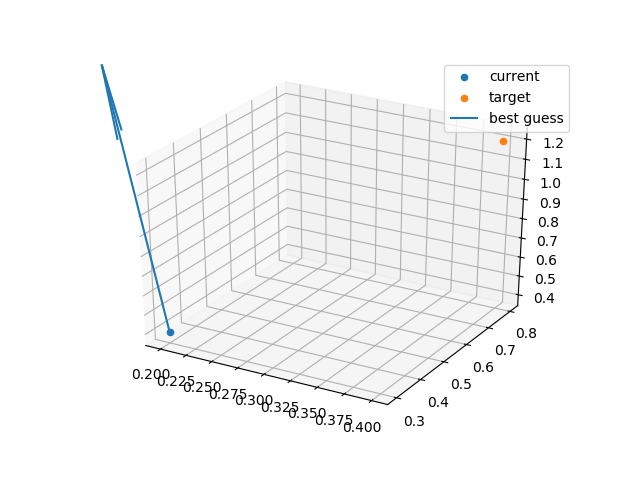

In [193]:
fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(current[0],current[1],current[2],label='current')
#ax.quiver(current[0],current[1],current[2],a[0],a[1],a[2],cmap='Reds',label='xi1')
#ax.quiver(current[0],current[1],current[2],b[0],b[1],b[2],label='xi2')
ax.scatter(target[0],target[1],target[2],label='target')
#ax.quiver(current[0],current[1],current[2],bg[0],bg[1],bg[2],label='best guess')
ax.quiver(current[0],current[1],current[2],cev[0],cev[1],cev[2],label='best guess')
plt.legend()

In [153]:
a

array([ 0.22532981,  0.96733163, -0.11617224])

In [154]:
b

array([ 0.03491134, -0.99936292, -0.00741233])

In [155]:
a.dot(b)

-0.9579876974085005

In [171]:
bg

array([-0.10506346, -0.99270445,  0.05915695])

In [172]:
target-current

array([0.2, 0.5, 0.8])

In [173]:
bg**2

array([0.01103833, 0.98546212, 0.00349955])

In [174]:
bg.dot(bg)

1.0

In [175]:
xi1 = foo(x)

In [176]:
xi2 = bar(x)

In [177]:
xi1

array([ 0.61326192, -0.316802  , -0.723565  ])

In [178]:
xi2

array([ 0.35810507,  0.92800188, -0.10282637])

In [179]:
xi1.dot(xi2)

2.0905457913403258e-05

In [180]:
r = target-current

In [181]:
r/=np.linalg.norm(r)

In [182]:
r

array([0.20739034, 0.51847585, 0.82956136])

In [183]:
r.dot(xi1)

-0.637311151853162

In [184]:
a1 = r.dot(xi1)

In [185]:
a2 = r.dot(xi2)

In [186]:
a2

0.47011331585957106

In [187]:
cev = a1*xi1 + a2*xi2

In [191]:
cev

array([-0.28094348,  0.80583416,  0.52125049])

In [189]:
bg

array([-0.10506346, -0.99270445,  0.05915695])

In [190]:
cev /= np.linalg.norm(cev)

In [194]:
cev.dot(r)

0.7919498476413459

In [195]:
r

array([0.20739034, 0.51847585, 0.82956136])